In [8]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import json

df = pd.read_csv('../assets/dataset.csv')
params_config = json.load(open('../config/lgm_model_best_params.json'))

features = [
    'surface_type', 
    'liquid_type', 
    'diameter',
    'height',
    'fall_point_type',
    'time',
]
label = 'area'

X = df[features]
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 获取测试集中的 src 字段（从原始 df 中获取）
X_test_with_src = df.loc[X_test.index, ['src']]

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',  
    'metric': 'rmse',          
    'boosting_type': 'gbdt',  
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}
print(params)

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,         
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

{'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': -1, 'verbose': -1}
RMSE: 0.0000


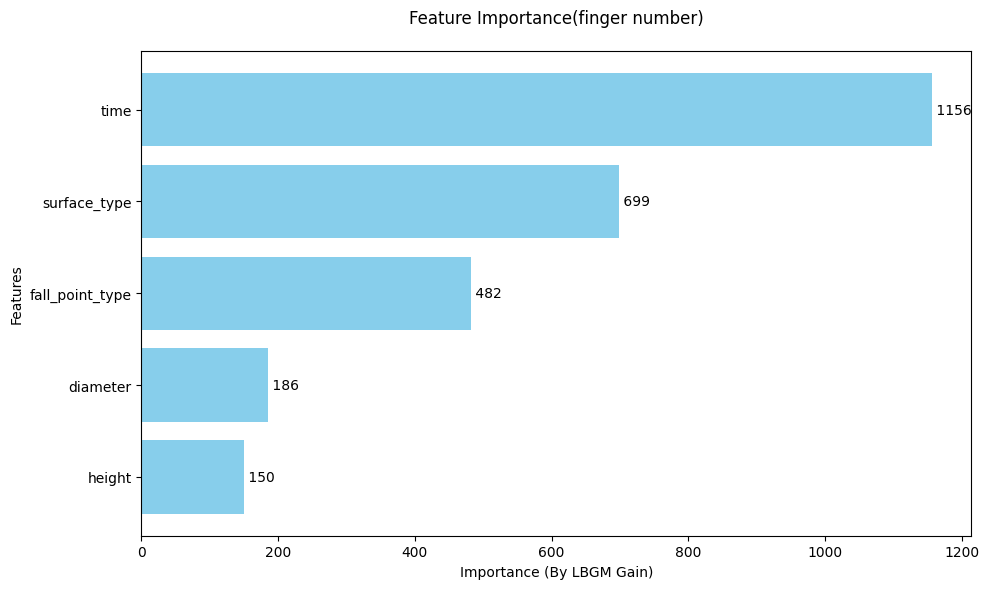

In [25]:
# import matplotlib.pyplot as plt

# # Set figure size explicitly

# fig,ax = plt.subplots(figsize=(10,8))

# # Create the feature importance plot
# lgb.plot_importance(model, 
#                    max_num_features=10, 
#                    importance_type='gain',
#                    title=f'Feature Importance({label})',
#            			ax=ax)
# # plt.tight_layout()  # Adjust layout to prevent label cutoff
# plt.show()

import matplotlib.pyplot as plt

# Feature importances
feature_importances = {
    'time': 1156,
    'surface_type': 699,
    'fall_point_type': 482,
    'height': 150,
    'diameter': 186,
}

# feature_importances:
# time=1156
# surface_type=696
# fall_point_type=482
# diameter=186
# height=150

# Sort features by importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=False)
features, importances = zip(*sorted_features)

# Create figure and axis
plt.figure(figsize=(10, 6))

# Create horizontal bar plot
plt.barh(features, importances, color='skyblue')

# Customize the plot
plt.title(f'Feature Importance(finger number)', fontsize=12, pad=20)
plt.xlabel('Importance (By LBGM Gain)', fontsize=10)
plt.ylabel('Features', fontsize=10)

# Add value labels on the bars
for i, v in enumerate(importances):
    plt.text(v, i, f' {v}', va='center')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [3]:
# results_df = X_test.copy()
# results_df['actual_value'] = y_test.values 
# results_df['predicted_value'] = y_pred     

# results_df['percentage_error'] = abs((results_df['predicted_value'] - results_df['actual_value']) / results_df['actual_value']) * 100
# results_df_with_src = results_df.join(X_test_with_src)
# bad_samples_df = results_df_with_src[results_df_with_src['percentage_error'] > 20]
# bad_samples_with_src = bad_samples_df[['src', 'actual_value', 'predicted_value', 'percentage_error']]
# bad_samples_with_src.to_csv(f'../assets/bad-case/{label}.csv', index=False)

# print(bad_samples_with_src.head())

In [4]:
results_df = X_test.copy()
results_df['actual_value'] = y_test.values 
results_df['predicted_value'] = y_pred     

results_df['percentage_error'] = abs((results_df['predicted_value'] - results_df['actual_value']) / results_df['actual_value']) * 100
results_df_with_src = results_df.join(X_test_with_src)
bad_samples_df = results_df_with_src #[results_df_with_src['percentage_error'] > 20]
bad_samples_with_src = bad_samples_df[['src', 'actual_value', 'predicted_value', 'percentage_error']]
bad_samples_with_src.to_csv(f'../assets/test-case/{label}.csv', index=False)

print(bad_samples_with_src.head())

                                                   src  actual_value  \
247  D:\records\Drop Impact on Rough Surfaces0\S2-W...      0.325907   
575  D:\records\Drop Impact on Rough Surfaces_2\SQ1...      0.597643   
227  D:\records\Drop Impact on Rough Surfaces0\S2-W...      0.567979   
290  D:\records\Drop Impact on Rough Surfaces0\S3-W...      0.500892   
538  D:\records\Drop Impact on Rough Surfaces_1\S6-...      0.346115   

     predicted_value  percentage_error  
247         0.283010         13.162353  
575         0.574670          3.843872  
227         0.574059          1.070356  
290         0.503496          0.520000  
538         0.386841         11.766513  


In [5]:
model.dump_model()

{'name': 'tree',
 'version': 'v4',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 5,
 'objective': 'regression',
 'average_output': False,
 'feature_names': ['surface_type',
  'liquid_type',
  'diameter',
  'height',
  'fall_point_type',
  'time'],
 'monotone_constraints': [],
 'feature_infos': {'surface_type': {'min_value': 0,
   'max_value': 8,
   'values': []},
  'diameter': {'min_value': 18, 'max_value': 25, 'values': []},
  'height': {'min_value': 20, 'max_value': 40, 'values': []},
  'fall_point_type': {'min_value': 0, 'max_value': 9, 'values': []},
  'time': {'min_value': 0.0182, 'max_value': 0.072, 'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 26,
   'num_cat': 0,
   'shrinkage': 1,
   'tree_structure': {'split_index': 0,
    'split_feature': 3,
    'split_gain': 3.0035200119018555,
    'threshold': 25.000000000000004,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value':

In [14]:
model.save_model(f'../model/model_{label}.txt')